In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc

import CHLpredictor as chl

CLOSE_IND = 0
LOW_IND = 0
HIGH_IND = 0
VOLUME_IND = 1

OUT_VALUE = HIGH_IND

data = pd.read_csv('AMZN.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

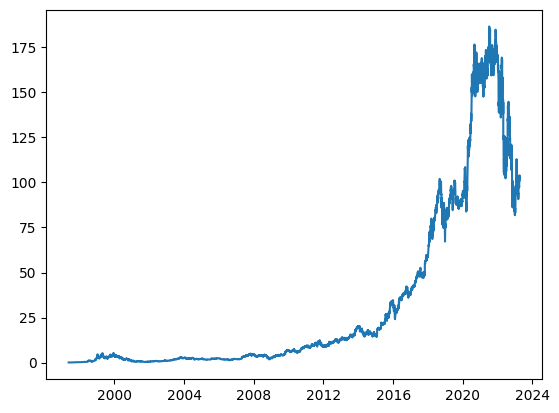

In [3]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [4]:
lookback = 7
df1, df2, df3, df4 = chl.prepare_dataframe_for_lstm_with_date(data, lookback)
df1



,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [5]:
df1_np = df1.to_numpy()
df2_np = df2.to_numpy()
df3_np = df3.to_numpy()
df4_np = df4.to_numpy()

df1_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaler4 = MinMaxScaler(feature_range=(-1, 1))
df1_np_scaled = scaler1.fit_transform(df1_np)
df2_np_scaled = scaler1.fit_transform(df2_np)
df3_np_scaled = scaler1.fit_transform(df3_np)
df4_np_scaled = scaler4.fit_transform(df4_np)

scaler = [scaler1, scaler1, scaler1, scaler4]

df1_np_scaled

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [7]:
# X = np.array([df1_np[:, 1:], df2_np[:, 1:], df3_np[:, 1:], df4_np[:, 1:]])
# y = np.array([df1_np[:, 0], df2_np[:, 0], df3_np[:, 0], df4_np[:, 0]])

X = np.zeros((len(df1_np), 4 * lookback))
y = np.zeros((len(df1_np), 3))
for i in range(0,len(df1_np)):
    X[i] = np.hstack((df1_np_scaled[i,1:], df2_np_scaled[i,1:], df3_np_scaled[i,1:], df4_np_scaled[i,1:]))
    y[i] = np.hstack((df1_np_scaled[i,0], df2_np_scaled[i,0], df3_np_scaled[i,0]))

X.shape, y.shape

((6509, 28), (6509, 3))

In [8]:
X = dc(np.flip(X, axis=1)) #flip left right
X

array([[ 0.38034321, -0.72626105, -0.89176634, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.72626105, -0.89176634, -0.90408505, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.89176634, -0.90408505, -0.6462703 , ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [-0.9539538 , -0.95536353, -0.96439081, ...,  0.07431453,
         0.09308121,  0.10690997],
       [-0.95536353, -0.96439081, -0.97209597, ...,  0.09308121,
         0.10691495,  0.09747299],
       [-0.96439081, -0.97209597, -0.96144209, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [9]:
split_index = int(len(X) * 0.95)

split_index

6183

In [10]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 28), (326, 28), (6183, 3), (326, 3))

In [11]:
X_train = X_train.reshape((-1, lookback*4, 1))
X_test = X_test.reshape((-1, lookback*4, 1))

y_train = y_train.reshape((-1, 3))
y_test = y_test.reshape((-1, 3))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 28, 1), (326, 28, 1), (6183, 3), (326, 3))

In [12]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 28, 1]),
 torch.Size([326, 28, 1]),
 torch.Size([6183, 3]),
 torch.Size([326, 3]))

In [13]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [14]:
train_dataset

In [15]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 28, 1]) torch.Size([16, 3])


In [17]:
from CHLpredictor import CHLpredictor

model = CHLpredictor(device, 1, 4, 1, 3)
model.to(device)
model

CHLpredictor(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=3, bias=True)
)

In [18]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss_across_batches = running_loss / len(train_loader)
    print('Train Loss: {0:.3f}'.format(avg_loss_across_batches))

In [19]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            writer.add_scalar("Loss/train", loss, epoch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [20]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss() #chl.CHLLoss() #nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    
torch.save(model, "checkpoints/chkpoint_" + str(epoch) + ".pt")
writer.flush()
writer.close()

Epoch: 1
Train Loss: 0.134
Val Loss: 0.258
***************************************************

Epoch: 2
Train Loss: 0.043
Val Loss: 0.050
***************************************************

Epoch: 3
Train Loss: 0.010
Val Loss: 0.042
***************************************************

Epoch: 4
Train Loss: 0.003
Val Loss: 0.022
***************************************************

Epoch: 5
Train Loss: 0.003
Val Loss: 0.008
***************************************************

Epoch: 6
Train Loss: 0.003
Val Loss: 0.005
***************************************************

Epoch: 7
Train Loss: 0.003
Val Loss: 0.004
***************************************************

Epoch: 8
Train Loss: 0.003
Val Loss: 0.004
***************************************************

Epoch: 9
Train Loss: 0.002
Val Loss: 0.004
***************************************************

Epoch: 10
Train Loss: 0.002
Val Loss: 0.004
***************************************************


(6183, 3)


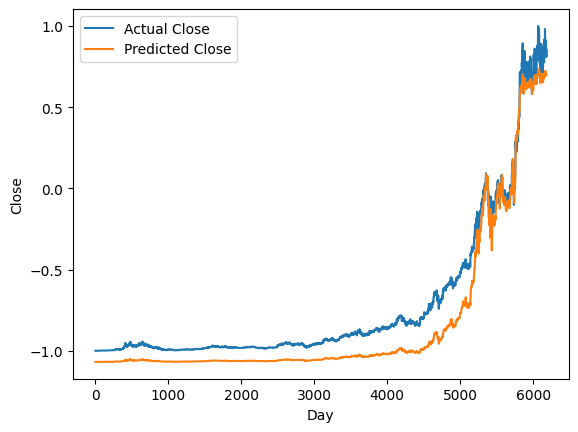

In [21]:
model = torch.load("checkpoints/chkpoint_99.pt")
model.eval()

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

print(predicted.shape)

plt.plot(y_train[:,OUT_VALUE], label='Actual Close')
plt.plot(predicted[:,OUT_VALUE], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


# Translate back to real prices

In [22]:
train_predictions = predicted[:,OUT_VALUE].flatten()
print(train_predictions.shape, X_train.shape)

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions

dummies = scaler[OUT_VALUE].inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

(6183,) torch.Size([6183, 28, 1])


array([ -6.39526556,  -6.39518688,  -6.3960861 , ..., 160.66401508,
       160.34976674, 159.90004009])

In [23]:
X_train.shape, y_train.shape

(torch.Size([6183, 28, 1]), torch.Size([6183, 3]))

In [24]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train[:, OUT_VALUE].flatten()
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([8.29035417e-02, 8.02733312e-02, 7.89526059e-02, ...,
       1.70980088e+02, 1.75250685e+02, 1.70757127e+02])

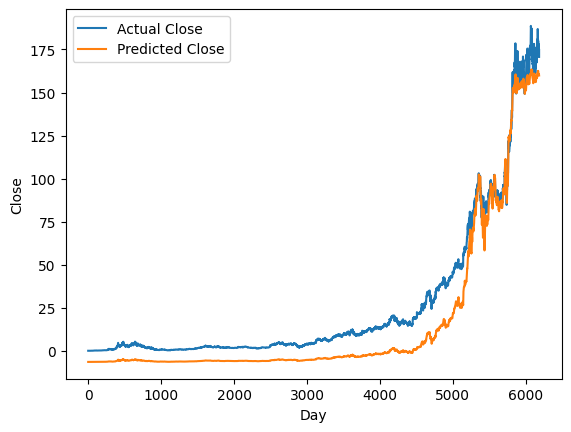

In [25]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [26]:
OUT_VALUE = CLOSE_IND

test_predictions_all = model(X_test.to(device)).detach().cpu().numpy()
test_predictions = test_predictions_all[:,OUT_VALUE].flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([159.92620731, 159.53774546, 159.36474167, 159.00623499,
       159.09483599, 159.28580164, 159.37811753, 159.39601195,
       159.4620707 , 159.44244529, 159.26079778, 158.90442112,
       158.9482973 , 158.73603144, 158.17162087, 157.60020202,
       156.94496488, 156.57453233, 156.6593229 , 156.67175458,
       156.37364719, 156.05951688, 155.38134408, 154.23819166,
       151.91314741, 149.19520703, 146.94389297, 144.78074717,
       143.33028162, 143.109136  , 144.35894683, 146.22201259,
       147.67981238, 147.34714695, 147.559913  , 149.52062814,
       151.33709197, 152.89430584, 153.80357186, 153.83476908,
       153.43978227, 153.05520953, 153.02415281, 152.96341069,
       152.43739107, 151.62162117, 150.28619361, 149.19821379,
       149.39820533, 149.94708754, 150.23705139, 150.25540666,
       149.9509598 , 149.07151408, 147.06948552, 144.36626983,
       142.59448586, 142.86918549, 144.07433332, 144.59297936,
       145.11566063, 146.56637908, 148.59354638, 150.70

In [27]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test[:,OUT_VALUE].flatten()
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([171.91640963, 168.94513727, 172.32037174, 172.94728354,
       172.97912707, 171.56452343, 172.56708324, 171.09081016,
       170.52809686, 168.57909964, 172.30772088, 169.39308235,
       166.19277935, 165.07748018, 164.36967817, 163.28975758,
       167.2089904 , 167.05226245, 163.0147376 , 163.94903558,
       160.69261581, 158.04491554, 153.36176394, 144.2366308 ,
       146.15883134, 141.5499888 , 140.42407606, 141.19760523,
       145.58651327, 151.24441639, 152.88248113, 152.29500564,
       140.39678201, 159.40036754, 159.699672  , 163.21645452,
       162.98995855, 160.77957573, 155.00590402, 156.90030188,
       158.2587775 , 159.86650491, 156.38005412, 154.30618373,
       151.87536904, 146.44497913, 153.04881947, 155.50641959,
       155.27841181, 152.83040521, 153.75106881, 149.55073505,
       147.26806641, 138.98875109, 137.53419972, 140.8351167 ,
       148.45768589, 147.15026895, 143.43781114, 149.01280643,
       154.81429206, 158.99539942, 163.05164485, 163.29

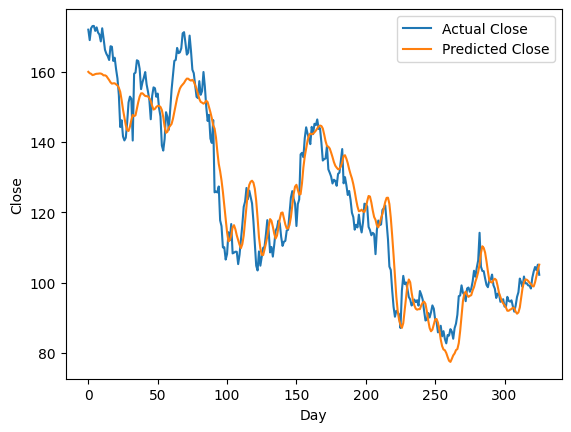

In [28]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


Root Mean Square Error:  0.16107700219289126 %
Std: 3.9987748431058083 %


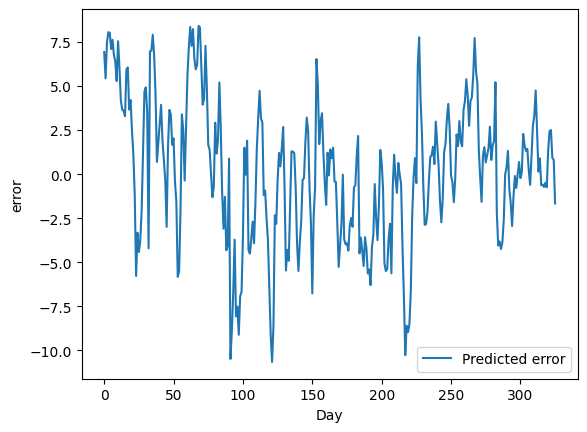

In [29]:
import math

MSE = np.square(np.subtract(new_y_test,test_predictions).mean()) 
RMSE = math.sqrt(MSE)
RMSE_pec = RMSE / new_y_test.max() * 100
print("Root Mean Square Error: ", RMSE_pec, "%")

print("Std:", np.subtract(new_y_test,test_predictions).std()/new_y_test.max()*100, "%")

plt.plot(np.subtract(new_y_test,test_predictions)/new_y_test.max()*100, label='Predicted error')
plt.xlabel('Day')
plt.ylabel('error')
plt.legend()
plt.show()

In [30]:
test_predictions

array([159.92620731, 159.53774546, 159.36474167, 159.00623499,
       159.09483599, 159.28580164, 159.37811753, 159.39601195,
       159.4620707 , 159.44244529, 159.26079778, 158.90442112,
       158.9482973 , 158.73603144, 158.17162087, 157.60020202,
       156.94496488, 156.57453233, 156.6593229 , 156.67175458,
       156.37364719, 156.05951688, 155.38134408, 154.23819166,
       151.91314741, 149.19520703, 146.94389297, 144.78074717,
       143.33028162, 143.109136  , 144.35894683, 146.22201259,
       147.67981238, 147.34714695, 147.559913  , 149.52062814,
       151.33709197, 152.89430584, 153.80357186, 153.83476908,
       153.43978227, 153.05520953, 153.02415281, 152.96341069,
       152.43739107, 151.62162117, 150.28619361, 149.19821379,
       149.39820533, 149.94708754, 150.23705139, 150.25540666,
       149.9509598 , 149.07151408, 147.06948552, 144.36626983,
       142.59448586, 142.86918549, 144.07433332, 144.59297936,
       145.11566063, 146.56637908, 148.59354638, 150.70

In [31]:
bad = [index for index,value in enumerate(test_predictions_all) if value[1] > value[0]]
bad = bad + [index for index,value in enumerate(test_predictions_all) if value[2] < value[0]]
test_predictions_all[bad]

array([[ 0.6953243 ,  0.86813945,  0.9965914 ],
       [ 0.6912044 ,  0.8634306 ,  0.9876954 ],
       [ 0.6893696 ,  0.85643804,  0.97524995],
       ...,
       [ 0.08068147,  0.33250695, -0.1195946 ],
       [ 0.09903881,  0.3369584 , -0.10601583],
       [ 0.11398688,  0.34156483, -0.09313148]], dtype=float32)